In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n'

In [2]:
import pandas as pd

In [3]:
df_meta = pd.read_csv("/kaggle/input/nih-sampled-data-with-localization/data_train/kaggle/working/data/train_meta_data.csv")

In [4]:
import json

with open("/kaggle/input/nih-sampled-data-with-localization/data_train/kaggle/working/data/disease_details.json") as f:
    data = json.load(f)

In [5]:
target_labels = data["diseases"]

In [6]:
target_labels

['Emphysema',
 'Infiltration',
 'Pleural_Thickening',
 'Pneumothorax',
 'Cardiomegaly',
 'Atelectasis',
 'Edema',
 'Effusion',
 'Consolidation',
 'Mass',
 'Nodule',
 'Fibrosis',
 'Pneumonia',
 'Hernia']

In [7]:
path_prefix = "/kaggle/input/nih-sampled-data-with-localization/data_train/kaggle/working/data/train_data/"

In [8]:
df_meta["image_path"] = df_meta["Image Index"].apply(lambda x: path_prefix+x)

In [9]:
import ast

df_meta["Encoded"] = df_meta["Encoded"].apply(lambda x: ast.literal_eval(x))

In [10]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd

# --- Prepare input arrays ---
y = np.stack(df_meta["Encoded"].values)        # shape: (n_samples, n_labels)
X = df_meta.drop(columns=["Encoded"]).to_numpy()

In [11]:
# --- Perform iterative stratified split ---
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

# --- Convert back to DataFrames ---
base_cols = list(df_meta.drop(columns=["Encoded"]).columns)
num_labels = y.shape[1]                         # will be 14 now
label_cols = list(range(num_labels))            # [0 ... 13]

# TRAIN
df_train_final = pd.DataFrame(
    np.hstack([X_train, y_train]),
    columns=base_cols + label_cols
)
df_train_final["Encoded"] = df_train_final[label_cols].values.tolist()
df_train_final.drop(columns=label_cols, inplace=True)

# Test
df_test_final = pd.DataFrame(
    np.hstack([X_test, y_test]),
    columns=base_cols + label_cols
)
df_test_final["Encoded"] = df_test_final[label_cols].values.tolist()
df_test_final.drop(columns=label_cols, inplace=True)

print(f"Train shape: {df_train_final.shape} | Test shape: {df_test_final.shape}")

Train shape: (16644, 6) | Test shape: (4161, 6)


In [92]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoImageProcessor

"""
class MedicalImageTransformerEncoder(nn.Module):
    def __init__(self,
                 model_name="microsoft/rad-dino",
                 proj_dim=256,
                 adapter_dim=128,
                 freeze_backbone=True):
        super().__init__()

        # Load pretrained Swin Transformer backbone
        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.processor = AutoImageProcessor.from_pretrained(model_name)

        # Optionally freeze the backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Hidden dimension of Swin model
        hidden_dim = self.backbone.config.hidden_size

        # Lightweight LoRA-style adapter
        self.adapter = nn.Sequential(
            nn.Linear(hidden_dim, adapter_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(adapter_dim, hidden_dim)
        )
        self.adapter_gate = nn.Parameter(torch.tensor(0.1))  # start small

        # Projection head for downstream fusion or retrieval
        self.projection = nn.Linear(hidden_dim, proj_dim)

        # Optional normalization
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, pixel_values, return_patches = False):
        
        Args:
            pixel_values (torch.Tensor): [B, 3, H, W]
        Returns:
            emb (torch.Tensor): [B, proj_dim] - projected embedding
            pooled (torch.Tensor): [B, hidden_dim] - pooled Swin features
        
        # Extract features from Swin backbone
        outputs = self.backbone(pixel_values=pixel_values)

        # Swin outputs `last_hidden_state` of shape [B, num_patches, hidden_dim]
        hidden_states = outputs.last_hidden_state

        # Global average pooling across spatial patches
        pooled = hidden_states.mean(dim=1)  # [B, hidden_dim]

        # Normalize (optional, improves stability)
        pooled = self.norm(pooled)

        # Adapter fine-tuning (trainable)
        adapted = pooled + self.adapter_gate * self.adapter(pooled)

        # Project to lower-dimensional embedding
        adapted = self.dropout(adapted)
        emb = self.projection(adapted)

        if return_patches:
            return emb, pooled, hidden_states  # ✅ return patch-level features

        return emb, pooled
"""

class MedicalImageTransformerEncoder(nn.Module):
    """
    Rad-DINO (or any HF vision transformer backbone) encoder that returns:
      - global projected embedding: [B, proj_dim]
      - pooled hidden state:        [B, hidden_dim]
      - final patch hidden states:  [B, P, hidden_dim]   (after adapter)
      - final patch projected:      [B, P, proj_dim]     (after adapter + projection)
    """
    def __init__(
        self,
        model_name: str = "microsoft/rad-dino",
        proj_dim: int = 256,
        adapter_dim: int = 128,
        freeze_backbone: bool = True,
        adapter_dropout: float = 0.1,
        head_dropout: float = 0.2,
    ):
        super().__init__()

        # --- backbone ---
        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.processor = AutoImageProcessor.from_pretrained(model_name)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Most ViT-like backbones expose hidden_size
        hidden_dim = getattr(self.backbone.config, "hidden_size", None)
        if hidden_dim is None:
            raise ValueError(
                "Backbone config has no `hidden_size`. "
                "Check the model config fields (e.g., hidden_size / embed_dim)."
            )

        self.hidden_dim = hidden_dim
        self.proj_dim = proj_dim

        # --- token-wise adapter (works for [B,H] and [B,P,H]) ---
        self.adapter = nn.Sequential(
            nn.Linear(hidden_dim, adapter_dim),
            nn.GELU(),
            nn.Dropout(adapter_dropout),
            nn.Linear(adapter_dim, hidden_dim),
        )
        # small start like LoRA/adapter gating
        self.adapter_gate = nn.Parameter(torch.tensor(0.1))

        # --- projection head ---
        self.projection = nn.Linear(hidden_dim, proj_dim)

        # --- normalization/dropout ---
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(head_dropout)

    def forward(
        self,
        pixel_values: torch.Tensor,
        return_patches: bool = False,
        project_patches: bool = True,
    ):
        """
        Args:
            pixel_values: [B, 3, H, W]
            return_patches: if True returns patch-level tensors
            project_patches: if True also returns projected patch embeddings [B,P,proj_dim]
        Returns:
            emb:        [B, proj_dim]
            pooled:     [B, hidden_dim]  (final pooled after adapter)
            patches_h:  [B, P, hidden_dim] (final patch hidden after adapter)         if return_patches
            patches_p:  [B, P, proj_dim]   (final patch projected after adapter+proj) if return_patches and project_patches
        """
        outputs = self.backbone(pixel_values=pixel_values, return_dict=True)

        # backbone patches
        # [B, P, H]
        patches = outputs.last_hidden_state

        # token-wise normalization
        patches = self.norm(patches)

        # token-wise adapter update
        patches_final = patches + self.adapter_gate * self.adapter(patches)  # [B,P,H]

        # pool AFTER adapter (so pooled represents final encoder state)
        pooled = patches_final.mean(dim=1)  # [B,H]

        # global embedding
        pooled_drop = self.dropout(pooled)
        emb = self.projection(pooled_drop)  # [B, proj_dim]

        if not return_patches:
            return emb, pooled

        if project_patches:
            patches_proj = self.projection(self.dropout(patches_final))  # [B,P,proj_dim]
            return emb, pooled, patches_final, patches_proj

        return emb, pooled, patches_final, None


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from PIL import Image
import timm
import numpy as np

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [14]:
import os
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from transformers import AutoImageProcessor

# ============================================================
# ✅ Class-aware augmentation for imbalance
# ============================================================
class ChestDataset(Dataset):
    def __init__(self, df, model_name="microsoft/rad-dino", img_size=224, train=True):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.processor = AutoImageProcessor.from_pretrained(model_name)

        # Define class rarity and stronger augmentations for rare diseases
        self.class_names = [
            'Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax',
            'Cardiomegaly', 'Atelectasis', 'Edema', 'Effusion',
            'Consolidation', 'Mass', 'Nodule', 'Fibrosis', 'Pneumonia', 'Hernia'
        ]

        self.medium_aug = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.02, rotate_limit=5, p=0.2),
        ])
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- Load image ---
        img = np.array(Image.open(row["image_path"]).convert("L"))
        img = np.stack([img, img, img], axis=-1)

        # --- Parse labels safely ---
        labels = row["Encoded"]
        if isinstance(labels, str):
            import ast
            try:
                labels = ast.literal_eval(labels)
            except Exception:
                labels = [0] * 14
        if not isinstance(labels, (list, np.ndarray)) or len(labels) != 14:
            labels = [0] * 14
        label = torch.tensor(labels, dtype=torch.float32)

        # --- Choose augmentation type ---
        if self.train:
            img = self.medium_aug(image=img)["image"]


        # --- Apply HF processor (normalization + tensor conversion) ---
        proc = self.processor(images=img, return_tensors="pt",do_center_crop=False,
    do_resize=True,
    size={"height": 518, "width": 518})
        img_tensor = proc["pixel_values"].squeeze(0)

        # --- Metadata ---
        age = torch.tensor([float(row["Patient Age"])], dtype=torch.float32)/100
        gender = 1.0 if str(row["Patient Gender"]).upper().startswith("M") else 0.0
        gender = torch.tensor([gender], dtype=torch.float32)

        return img_tensor, age, gender, label


In [91]:
import torch
import torch.nn as nn

"""

class BioViLTCompoundModel(nn.Module):
    def __init__(self, num_classes=14, freeze_encoder=True, dropout=0.3):
        super().__init__()

        # --- Shared image encoder ---
        self.encoder = MedicalImageTransformerEncoder(freeze_backbone=freeze_encoder)
        self.num_classes = num_classes

        # --- Metadata branch (age + gender) ---
        self.meta_fc = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # --- Shared fusion layer ---
        self.fusion = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # --- One-vs-All heads (1 per class) ---
        self.class_heads = nn.ModuleList([
            nn.Linear(128, 1) for _ in range(num_classes)
        ])

    def forward(self, image, age, gender, return_patches: bool = False):

        if return_patches:
            img_emb, pooled, patches = self.encoder(image, return_patches=True)
        else:
            img_emb, pooled = self.encoder(image)
            patches = None
        # 1. Image encoding
        #img_emb, _ = self.encoder(image)  # [B, 128]

        # 2. Metadata
        #meta = torch.cat((age, gender), dim=1)
        #meta_feat = self.meta_fc(meta)  # [B, 16]

        # 3. Fuse features
        #fused = torch.cat((img_emb, meta_feat), dim=1)
        shared_feat = self.fusion(img_emb)  # [B, 128]

        # 4. One-vs-All logits
        logits = torch.cat([head(shared_feat) for head in self.class_heads], dim=1)  # [B, num_classes]

        return logits, img_emb
"""
class BioViLTCompoundModel(nn.Module):
    """
    Uses:
      - image encoder global embedding for classification
      - can optionally output final patch projected features too
    """
    def __init__(self, num_classes: int = 14, freeze_encoder: bool = True, dropout: float = 0.3):
        super().__init__()

        self.encoder = MedicalImageTransformerEncoder(freeze_backbone=freeze_encoder)
        self.num_classes = num_classes

        # Global fusion
        self.fusion = nn.Sequential(
            nn.Linear(self.encoder.proj_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # One-vs-All heads
        self.class_heads = nn.ModuleList([nn.Linear(128, 1) for _ in range(num_classes)])

    def forward(
        self,
        image: torch.Tensor,
        age: torch.Tensor = None,
        gender: torch.Tensor = None,
        return_patches: bool = False,
        project_patches: bool = True,
    ):
        """
        Returns:
            logits: [B, num_classes]
            img_emb: [B, 256] (global projected)
            patches_final: [B,P,H] (optional)
            patches_proj: [B,P,256] (optional)
        """
        if return_patches:
            img_emb, pooled, patches_final, patches_proj = self.encoder(
                image,
                return_patches=True,
                project_patches=project_patches,
            )
        else:
            img_emb, pooled = self.encoder(image, return_patches=False)
            patches_final, patches_proj = None, None

        # Global classification
        shared_feat = self.fusion(img_emb)  # [B, 128]
        logits = torch.cat([head(shared_feat) for head in self.class_heads], dim=1)  # [B, C]

        if return_patches:
            # return projected patch tokens too (the thing you asked for)
            return logits, img_emb, patches_final, patches_proj

        return logits, img_emb, patches_final, None





In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

thresholds= [0.334,0.62,0.304,0.394,0.250,0.358,0.117,0.505,0.206,0.193,0.373,0.249,0.103,0.05]
thresholds = torch.tensor(thresholds).to(device)

In [17]:
df_test_final.head()

Diseases Patient Age Patient Gender  \
0       ['Infiltration', 'Nodule']           3              M   
1                     ['Effusion']           3              F   
2                 ['Infiltration']           1              F   
3  ['Atelectasis', 'Infiltration']           4              F   
4                 ['Cardiomegaly']           1              F   

        Image Index                                         image_path  \
0  00018145_003.png  /kaggle/input/nih-sampled-data-with-localizati...   
1  00010953_002.png  /kaggle/input/nih-sampled-data-with-localizati...   
2  00023352_000.png  /kaggle/input/nih-sampled-data-with-localizati...   
3  00015318_004.png  /kaggle/input/nih-sampled-data-with-localizati...   
4  00012798_000.png  /kaggle/input/nih-sampled-data-with-localizati...   

                                      Encoded  
0  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]  
1  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
3  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
4  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
df_test_final = df_test_final.drop(["Diseases","Image Index"], axis =1)

In [19]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

# ============================================================
# 2️⃣ HELPER FUNCTIONS
# ============================================================
def multilabel_accuracy(preds, targets, threshold):
    preds = (torch.sigmoid(preds) > 0.5).float()
    correct = (preds == targets).float()
    return correct.mean().item()

def multilabel_f1(preds, targets, threshold):
    preds = (torch.sigmoid(preds) > 0.5).cpu().numpy()
    targets = targets.cpu().numpy()
    f1s = f1_score(targets, preds, average=None,zero_division=0)
    f1_dict = {target_labels[i]: f1 for i, f1 in enumerate(f1s)}
    precision = precision_score(targets, preds, average="micro", zero_division=0)
    recall = recall_score(targets, preds, average="micro", zero_division=0)

    return f1_score(targets, preds, average="micro", zero_division=0), precision, recall, f1_dict

def multilabel_auc_roc_from_probs(y_pred, y_true, target_labels):
    """
    y_pred: numpy array probabilities (N, num_labels)
    y_true: numpy array labels (N, num_labels)
    """
    auc_dict = {}

    for i, label in enumerate(target_labels):
        if len(np.unique(y_true[:, i])) < 2:
            auc_dict[label] = np.nan
        else:
            auc_dict[label] = roc_auc_score(y_true[:, i], y_pred[:, i])

    macro_auc = float(np.nanmean(list(auc_dict.values())))

    try:
        micro_auc = roc_auc_score(y_true, y_pred, average="micro")
    except ValueError:
        micro_auc = np.nan

    return macro_auc, micro_auc, auc_dict

In [94]:
model = BioViLTCompoundModel(freeze_encoder=False)

In [22]:
import torch
import os

def load_model_checkpoint(model, checkpoint_path, device="cpu", optimizer=None, strict=True):
    """
    Loads model weights (and optionally optimizer) from a checkpoint file.

    Args:
        model (torch.nn.Module): The model instance to load weights into.
        checkpoint_path (str): Path to .pth or .pt file.
        device (str): "cpu" or "cuda".
        optimizer (torch.optim.Optimizer, optional): Optimizer to restore state.
        strict (bool): Whether to strictly enforce that keys match.

    Returns:
        model, optimizer, start_epoch, val_loss
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"❌ Checkpoint not found: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    start_epoch, val_loss = 0, None

    # Case 1 — checkpoint contains only model_state_dict
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"], strict=strict)
        if optimizer and "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint.get("epoch", 0)
        val_loss = checkpoint.get("val_loss", None)
        print(f"✅ Loaded model_state_dict from checkpoint (epoch={start_epoch})")

    # Case 2 — checkpoint is a raw state_dict
    elif isinstance(checkpoint, dict):
        model.load_state_dict(checkpoint, strict=strict)
        print("✅ Loaded raw state_dict directly")

    # Case 3 — full model object was saved
    else:
        model = checkpoint
        print("✅ Loaded entire model object (torch.save(model, ...))")

    model.to(device)
    model.eval()

    return model, optimizer, start_epoch, val_loss


In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BioViLTCompoundModel(num_classes=14)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model, optimizer, start_epoch, best_val_loss = load_model_checkpoint(
    model, "/kaggle/input/nih-train-model/pytorch/default/2/best_model (5).pth", device=device, optimizer=optimizer,strict=False
)

✅ Loaded raw state_dict directly


In [25]:
from tqdm import tqdm

def get_val_dataloader(dataset, batch_size=16, shuffle=False):
    optimal_workers = min(8, os.cpu_count() // 2)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=optimal_workers,
        pin_memory=True,
        prefetch_factor=4,
        persistent_workers=True
    )

val_dataset = ChestDataset(df_test_final, train=False)
val_loader = get_val_dataloader(val_dataset, shuffle=False)

In [ ]:

total_val_loss, total_val_acc, total_val_f1, total_val_precision, total_val_recall = 0.0, 0.0, 0.0, 0.0, 0.0

val_bar = tqdm(val_loader, desc="Validating", leave=False)
all_probs, all_labels = [], []

with torch.no_grad():
    for img, age, gender, labels in val_bar:
        img = img.to(device, non_blocking=True)
        age = age.to(device, non_blocking=True)
        gender = gender.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs, _ = model(img, age, gender)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())


        total_val_acc += multilabel_accuracy(outputs, labels, thresholds)
        f1, precision, recall, f1_dict = multilabel_f1(outputs, labels, thresholds)
        total_val_f1 += f1
        total_val_precision += precision
        total_val_recall += recall


Validating:  92%|█████████▏| 241/261 [03:21<00:16,  1.21it/s]

In [27]:
target_labels= ['Emphysema',
 'Infiltration',
 'Pleural_Thickening',
 'Pneumothorax',
 'Cardiomegaly',
 'Atelectasis',
 'Edema',
 'Effusion',
 'Consolidation',
 'Mass',
 'Nodule',
 'Fibrosis',
 'Pneumonia',
 'Hernia']

In [28]:
avg_val_acc = total_val_acc / len(val_loader)
avg_val_f1 = total_val_f1 / len(val_loader)
avg_val_precision = total_val_precision / len(val_loader)
avg_val_recall = total_val_recall / len(val_loader)


In [29]:
avg_val_acc

0.9074131517574705

In [30]:
avg_val_f1

0.42837256960481396

In [31]:
avg_val_precision

0.4785652707489778

In [32]:
avg_val_recall

0.39361869617505346

In [33]:
y_pred = np.concatenate(all_probs, axis=0)   # (N, 14)
y_true = np.concatenate(all_labels, axis=0) # (N, 14)

from sklearn.metrics import roc_auc_score

# --- AUROC (use probs + labels) ---
macro_auc, micro_auc, auc_dict = multilabel_auc_roc_from_probs(
    y_pred, y_true, target_labels
)

In [34]:
micro_auc

0.8699116125139456

In [35]:
macro_auc

0.8061598941582189

In [36]:
auc_dict

{'Emphysema': 0.9298543187465174,
 'Infiltration': 0.6795946986863536,
 'Pleural_Thickening': 0.7875393474001234,
 'Pneumothorax': 0.8525575228808484,
 'Cardiomegaly': 0.8317328408741151,
 'Atelectasis': 0.8076061229311338,
 'Edema': 0.8536278716222301,
 'Effusion': 0.8579736250950597,
 'Consolidation': 0.7140115510654862,
 'Mass': 0.8564339830198472,
 'Nodule': 0.7726741810942526,
 'Fibrosis': 0.7586442021803766,
 'Pneumonia': 0.6776359841974868,
 'Hernia': 0.906352268421234}

In [37]:
batch = next(iter(val_loader))

# Unpack
images, ages, genders, labels = batch

print("Images:", images.shape)       # [B, 3, H, W]
print("Ages:", ages.shape)           # [B, 1]
print("Genders:", genders.shape)     # [B, 1]
print("Labels:", labels.shape)       # [B, 14]

Images: torch.Size([16, 3, 518, 518])
Ages: torch.Size([16, 1])
Genders: torch.Size([16, 1])
Labels: torch.Size([16, 14])


In [38]:
images[0]

tensor([[[-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         ...,
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0394, -2.0394],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -1.9939, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0242, -1.9483, -2.0090]],

        [[-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         ...,
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0394, -2.0394],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0546, -1.9939, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2.0242, -1.9483, -2.0090]],

        [[-2.0546, -2.0546, -2.0546,  ..., -2.0546, -2.0242, -2.0242],
         [-2.0546, -2.0546, -2.0546,  ..., -2

In [39]:
outputs, _ = model(images.to(device), ages.to(device), genders.to(device))
probs = torch.sigmoid(outputs).cpu().detach().numpy()

In [40]:
probs

array([[0.10024174, 0.62968117, 0.15418656, 0.11179547, 0.35034227,
        0.35551804, 0.20186974, 0.14321274, 0.17231433, 0.12674542,
        0.22961718, 0.16840833, 0.22084351, 0.12510592],
       [0.08674622, 0.53470385, 0.17058134, 0.1752566 , 0.14207391,
        0.5579378 , 0.2168667 , 0.41316053, 0.36317194, 0.301636  ,
        0.2291181 , 0.09964334, 0.21277763, 0.11712253],
       [0.08483513, 0.51345795, 0.2040608 , 0.12944521, 0.3780835 ,
        0.141027  , 0.11386891, 0.15409228, 0.15503077, 0.16797385,
        0.30978593, 0.20670573, 0.1610921 , 0.1074053 ],
       [0.2737805 , 0.4721566 , 0.16991445, 0.33028725, 0.14346549,
        0.64239365, 0.21144715, 0.43850383, 0.33055916, 0.13124068,
        0.10714764, 0.10034079, 0.23131707, 0.12624513],
       [0.08390728, 0.59658355, 0.13203144, 0.17794952, 0.31354627,
        0.20738436, 0.16582818, 0.19357081, 0.22327325, 0.0923475 ,
        0.15553771, 0.12157079, 0.15103616, 0.08155023],
       [0.16400667, 0.42272827, 0.1

In [41]:
labels

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

In [42]:
probs[0]

array([0.10024174, 0.62968117, 0.15418656, 0.11179547, 0.35034227,
       0.35551804, 0.20186974, 0.14321274, 0.17231433, 0.12674542,
       0.22961718, 0.16840833, 0.22084351, 0.12510592], dtype=float32)

In [43]:
labels[0]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [44]:
probs[1]

array([0.08674622, 0.53470385, 0.17058134, 0.1752566 , 0.14207391,
       0.5579378 , 0.2168667 , 0.41316053, 0.36317194, 0.301636  ,
       0.2291181 , 0.09964334, 0.21277763, 0.11712253], dtype=float32)

In [45]:
labels[1]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [46]:
### handling bboxes
import pandas as pd

In [47]:
df_bbox = pd.read_csv("/kaggle/input/nih-sampled-data-with-localization/bbox_check/kaggle/working/data/bbox_metadata.csv")

In [48]:
df_bbox.head()

Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  
0   79.186441  
1  313.491525  
2  216.949153  
3   55.322034  
4   78.101695

In [49]:
df_bbox["Patient Age"] = 2
df_bbox["Patient Gender"] = "M"

In [50]:
df_bbox.head()

Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Patient Age Patient Gender  
0   79.186441            2              M  
1  313.491525            2              M  
2  216.949153            2              M  
3   55.322034            2              M  
4   78.101695            2              M

In [51]:
df_bbox["Finding Label"].unique()

array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax'], dtype=object)

In [52]:
df_bbox["Finding Label"]= df_bbox["Finding Label"].apply(lambda x: "Infiltration" if x == "Infiltrate" else x)

In [53]:
df_bbox.head()

Image Index Finding Label     Bbox [x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

           h]  Patient Age Patient Gender  
0   79.186441            2              M  
1  313.491525            2              M  
2  216.949153            2              M  
3   55.322034            2              M  
4   78.101695            2              M

In [54]:
df_bbox.columns

Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]',
       'Patient Age', 'Patient Gender'],
      dtype='object')

In [55]:
df_bbox.rename(columns={"Bbox [x": "x", "h]": "h"}, inplace=True)

In [56]:
df_bbox.head()

Image Index Finding Label           x           y           w  \
0  00013118_008.png   Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png   Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png   Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png   Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png   Atelectasis  660.067797  569.780787  200.677966   

            h  Patient Age Patient Gender  
0   79.186441            2              M  
1  313.491525            2              M  
2  216.949153            2              M  
3   55.322034            2              M  
4   78.101695            2              M

In [57]:
from sklearn.preprocessing import MultiLabelBinarizer

# Original 15 labels
target_labels = [
    'Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax',
    'Cardiomegaly', 'Atelectasis', 'Edema', 'Effusion',
    'Consolidation', 'Mass', 'Nodule', 'Fibrosis', 'Pneumonia', 'Hernia'
]

df_bbox["Finding Label"] = df_bbox["Finding Label"].apply(lambda x: [x])

mlb = MultiLabelBinarizer(classes=target_labels)
encoded = mlb.fit_transform(df_bbox["Finding Label"])

df_bbox["Encoded"] = encoded.tolist()

# Keep only useful columns
df_bbox= df_bbox[["Finding Label", "Encoded","Patient Age", "Patient Gender", "Image Index","x","y","h","w"]]

In [58]:
df_bbox.head(10)

Finding Label                                     Encoded  Patient Age  \
0  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
1  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
2  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
3  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
4  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
5  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
6  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
7  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
8  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
9  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   

  Patient Gender       Image Index           x           y           h  \
0              M  00013118_008.png  225.084746  547.019217   79.186441   
1              M  00014716_007.png  686.101695  131.543498  313.491525   
2              M  00029817_009.png  221.830508  317.053115  216.949153   
3              M  00014687_001.png  726.237288  494.951420   55.322034   
4              M  00017877_001.png  660.067797  569.780787   78.101695   
5              M  00003148_004.png  596.067797  505.780787  180.067797   
6              M  00012515_002.png  289.084746  638.137861   56.406780   
7              M  00022098_006.png  494.101695  577.392098  154.033898   
8              M  00014198_000.png  676.338983  512.307352  193.084746   
9              M  00021007_000.png  344.406780  468.917522  101.966102   

            w  
0   86.779661  
1  185.491525  
2  155.118644  
3  141.016949  
4  200.677966  
5   56.406780  
6   83.525424  
7  271.186441  
8   98.711864  
9  105.220339

In [59]:
df_bbox[df_bbox["Encoded"].apply(lambda x: sum(x)==0)]

Empty DataFrame
Columns: [Finding Label, Encoded, Patient Age, Patient Gender, Image Index, x, y, h, w]
Index: []

In [60]:
path_prefix = "/kaggle/input/nih-sampled-data-with-localization/bbox_check/kaggle/working/data/bbox_images/"

In [61]:
df_bbox["image_path"] = df_bbox["Image Index"].apply(lambda x: path_prefix+x)

In [62]:
df_bbox.head()

Finding Label                                     Encoded  Patient Age  \
0  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
1  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
2  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
3  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   
4  [Atelectasis]  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2   

  Patient Gender       Image Index           x           y           h  \
0              M  00013118_008.png  225.084746  547.019217   79.186441   
1              M  00014716_007.png  686.101695  131.543498  313.491525   
2              M  00029817_009.png  221.830508  317.053115  216.949153   
3              M  00014687_001.png  726.237288  494.951420   55.322034   
4              M  00017877_001.png  660.067797  569.780787   78.101695   

            w                                         image_path  
0   86.779661  /kaggle/input/nih-sampled-data-with-localizati...  
1  185.491525  /kaggle/input/nih-sampled-data-with-localizati...  
2  155.118644  /kaggle/input/nih-sampled-data-with-localizati...  
3  141.016949  /kaggle/input/nih-sampled-data-with-localizati...  
4  200.677966  /kaggle/input/nih-sampled-data-with-localizati...

In [63]:
df_bbox.drop(["Finding Label", "Image Index"], axis=1, inplace=True)

In [64]:
df_bbox

Encoded  Patient Age Patient Gender  \
0    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
1    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
2    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
3    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
4    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
..                                          ...          ...            ...   
979  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
980  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
981  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
982  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   
983  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            2              M   

              x           y           h           w  \
0    225.084746  547.019217   79.186441   86.779661   
1    686.101695  131.543498  313.491525  185.491525   
2    221.830508  317.053115  216.949153  155.118644   
3    726.237288  494.951420   55.322034  141.016949   
4    660.067797  569.780787   78.101695  200.677966   
..          ...         ...         ...         ...   
979  198.940451  352.900747  323.128889  615.537778   
980  701.838229  572.491858   63.715556  103.537778   
981  140.913785  658.962969   94.435556  271.928889   
982  175.047118  580.456302  103.537778  244.622222   
983  343.438229  446.198524   53.475556  120.604444   

                                            image_path  
0    /kaggle/input/nih-sampled-data-with-localizati...  
1    /kaggle/input/nih-sampled-data-with-localizati...  
2    /kaggle/input/nih-sampled-data-with-localizati...  
3    /kaggle/input/nih-sampled-data-with-localizati...  
4    /kaggle/input/nih-sampled-data-with-localizati...  
..                                                 ...  
979  /kaggle/input/nih-sampled-data-with-localizati...  
980  /kaggle/input/nih-sampled-data-with-localizati...  
981  /kaggle/input/nih-sampled-data-with-localizati...  
982  /kaggle/input/nih-sampled-data-with-localizati...  
983  /kaggle/input/nih-sampled-data-with-localizati...  

[984 rows x 8 columns]

In [65]:
df_bbox[df_bbox["Encoded"].apply(lambda x: sum(x)==0)]

Empty DataFrame
Columns: [Encoded, Patient Age, Patient Gender, x, y, h, w, image_path]
Index: []

In [66]:
df_bbox["Encoded"] = df_bbox["Encoded"].apply(lambda x: str(x))

In [67]:
val_dataset = ChestDataset(df_bbox, train=False)
val_loader = get_val_dataloader(val_dataset, batch_size =1, shuffle=False)

In [68]:
batch = next(iter(val_loader))

# Unpack
images, ages, genders, labels = batch

print("Images:", images.shape)       # [B, 3, H, W]
print("Ages:", ages.shape)           # [B, 1]
print("Genders:", genders.shape)     # [B, 1]
print("Labels:", labels.shape)       # [B, 14]

Images: torch.Size([1, 3, 518, 518])
Ages: torch.Size([1, 1])
Genders: torch.Size([1, 1])
Labels: torch.Size([1, 14])


In [69]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def visualize_bbox(df, index=0, color='red', linewidth=3, show_label=True, save_path=None):
    """
    Visualize bounding boxes for a given row index from df_bbox.

    Args:
        df (pd.DataFrame): dataframe with columns [x, y, h, w, image_path, Encoded]
        index (int): index of the row to visualize
        color (str): color of the bounding box
        linewidth (int): thickness of the bounding box
        show_label (bool): whether to show disease class label
        save_path (str): optional path to save the visualized image
    """

    # Extract row
    row = df.iloc[index]
    image_path = row["image_path"]
    x, y, h, w = row[["x", "y", "h", "w"]]
    label = None
    if "Encoded" in df.columns:
        label = row["Encoded"]

    # Load image
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_np, cmap="gray")

    # Draw bounding box
    rect = patches.Rectangle(
        (x, y), w, h,
        linewidth=linewidth,
        edgecolor=color,
        facecolor='none'
    )
    ax.add_patch(rect)

    # Label (optional)
    if show_label and label is not None:
        class_idx = np.argmax(label) if isinstance(label, (list, np.ndarray)) else label
        ax.text(
            x, y - 10,
            f"Class: {class_idx}",
            color=color,
            fontsize=12,
            weight='bold',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )

    ax.set_title(f"Bounding Box Visualization (Row {index})", fontsize=14)
    ax.axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        print(f"💾 Saved: {save_path}")

    plt.show()


In [70]:
thresholds= [0.334,0.62,0.304,0.394,0.250,0.358,0.117,0.505,0.206,0.193,0.373,0.249,0.103,0.05]
thresholds = torch.tensor(thresholds).to(device)

In [114]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt


def generate_gradcam_explanations(
    model,
    df,
    thresholds,
    index=0,
    class_names=None,
    device="cuda",
    save_dir=None,
    alpha=0.4,
    use_projected_patches: bool = True,   # ✅ use patch projection tokens for CAM
    drop_cls: bool = True                # ✅ if backbone has CLS token
):
    """
    Generate Grad-CAM visualizations for all active labels in a multi-label prediction
    using patch tokens (preferably projected patch tokens).

    Updated for new model outputs:
        BioViLTCompoundModel forward(return_patches=True) returns:
            logits, img_emb, patches_final, patches_proj

    Args:
        model: BioViLTCompoundModel
        df: dataframe
        thresholds: tensor/np array/list of thresholds (len=num_classes)
        index: sample index from df
        class_names: optional list of class names
        device: cuda/cpu
        save_dir: if set, save overlays
        alpha: overlay blending factor
        use_projected_patches: if True uses patches_proj [B,P,proj_dim] else patches_final [B,P,hidden_dim]
        drop_cls: drop CLS token if patch seq includes CLS

    Returns:
        heatmaps: dict {class_idx: np.ndarray (patch_grid_h, patch_grid_w)}
    """

    model.eval()
    model.zero_grad()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # ---- Load single sample (your dataset pipeline) ----
    df_1 = df.iloc[[index]]
    val_dataset = ChestDataset(df_1, train=False)
    val_loader = get_val_dataloader(val_dataset, batch_size=1, shuffle=False)
    batch = next(iter(val_loader))

    # batch unpack
    image, age, gender, label_vector = batch

    # ---- to device ----
    image = image.to(device)
    age = age.to(device)
    gender = gender.to(device)

    # label vector
    if isinstance(label_vector, list):
        label_vector = torch.tensor(label_vector, dtype=torch.float32)
    label_vector = label_vector.to(device)

    # thresholds
    if isinstance(thresholds, (list, np.ndarray)):
        thresholds = torch.tensor(thresholds, dtype=torch.float32, device=device)
    else:
        thresholds = thresholds.to(device)

    # ----------------------------------------------------------
    # Forward pass with patch output
    # ----------------------------------------------------------
    # UPDATED: model returns 4 values in patch mode
    with torch.set_grad_enabled(True):
        # force gradient tracking for CAM
        logits, img_emb, patches_final,_ = model(
            image,
            age=age,
            gender=gender,
            return_patches=True,
            project_patches=False
        )

    # choose patch tensor for CAM
    patch_feats = patches_final
    # IMPORTANT: patch tensor must require grads for Grad-CAM
    patch_feats.retain_grad()

    preds = (torch.sigmoid(logits) > thresholds).float()
    #print("Predictions:", preds.detach().cpu().numpy())

    # ----------------------------------------------------------
    # Determine active classes
    # ----------------------------------------------------------
    # You said "active labels" => from label_vector, not preds
    active_indices = (label_vector[0] > 0).nonzero(as_tuple=True)[0]

    if len(active_indices) == 0:
        print("⚠️ No active labels found for this sample.")
        return {}

    heatmaps = {}

    # ----------------------------------------------------------
    # Grad-CAM per class
    # ----------------------------------------------------------
    for c_idx in active_indices.tolist():
        model.zero_grad()

        # backward score for class c
        score = logits[0, c_idx]
        score.backward(retain_graph=True)

        # gradients wrt patch feats
        grad = patch_feats.grad              # [B,P,D]
        feat = patch_feats.detach()          # [B,P,D]

        if grad is None:
            raise RuntimeError(
                "patch_feats.grad is None. "
                "Make sure patch_feats.retain_grad() is called and backward runs."
            )

        # Grad-CAM weights: average gradient over tokens (P dimension) or channels?
        # Standard transformer Grad-CAM:
        # weights per channel = mean over tokens
        weights = grad.mean(dim=1, keepdim=True)     # [B,1,D]
        cam = (weights * feat).sum(dim=-1)           # [B,P]
        cam = cam.squeeze(0).detach().cpu().numpy()  # [P]

        # optional: drop CLS
        if drop_cls and cam.shape[0] > 1:
            cam = cam[1:]

        # reshape to square grid
        n_tokens = cam.shape[0]
        n_side = int(np.sqrt(n_tokens))

        # safety if not perfect square
        if n_side * n_side != n_tokens:
            # Try best-effort rectangle
            n_side = int(np.floor(np.sqrt(n_tokens)))
            cam = cam[: n_side * n_side]
            n_tokens = cam.shape[0]

        cam = cam.reshape(n_side, n_side)

        # normalize CAM
        cam = np.maximum(cam, 0)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        heatmaps[c_idx] = cam

        # ----------------------------------------------------------
        # Overlay visualization
        # ----------------------------------------------------------
        img_np = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        img_uint8 = np.uint8(255 * img_np)

        cam_resized = cv2.resize(cam, (img_uint8.shape[1], img_uint8.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

        overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap_color, alpha, 0)

        title = class_names[c_idx] if class_names else f"Class_{c_idx}"
        plt.figure(figsize=(5, 5))
        plt.title(f"Grad-CAM ({'proj' if use_projected_patches else 'hidden'}): {title}")
        plt.imshow(overlay[..., ::-1])  # BGR->RGB
        plt.axis("off")
        plt.show()

        # Save if needed
        if save_dir:
            safe_title = str(title).replace(" ", "_").replace("/", "_")
            save_path = os.path.join(save_dir, f"gradcam_{safe_title}.png")
            cv2.imwrite(save_path, overlay)  # overlay is BGR already
            #print(f"💾 Saved: {save_path}")

        # reset grads for next class CAM
        patch_feats.grad = None

    return heatmaps


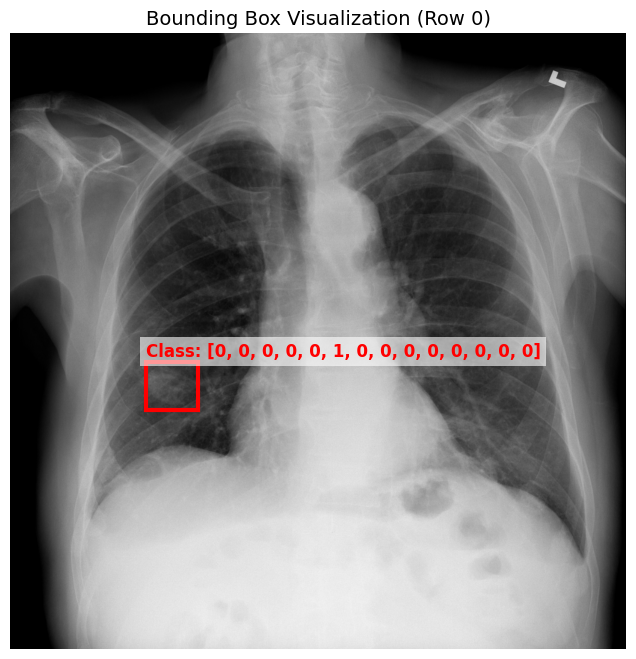

In [78]:
visualize_bbox(df_bbox)

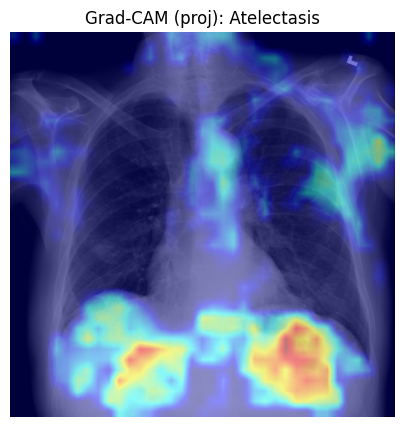

In [115]:
# Example inputs
class_names = [
    'Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax',
    'Cardiomegaly', 'Atelectasis', 'Edema', 'Effusion',
    'Consolidation', 'Mass', 'Nodule', 'Fibrosis', 'Pneumonia', 'Hernia', 'Other'
]

# Run Grad-CAM
heatmaps = generate_gradcam_explanations(
    model,
    df_bbox,
    thresholds,
    0,
    class_names=class_names,
    save_dir="gradcam_outputs",
    alpha=0.45
)


In [ ]:
row=df_bbox.iloc[0]

In [ ]:
row["image_path"]

In [99]:
def combined_visulizer(model, df, index, thresholds, class_names):

    heatmaps = generate_gradcam_explanations(
    model,
    df,
    thresholds,
    index,
    class_names=class_names,
    save_dir="gradcam_outputs",
    alpha=0.45)

    visualize_bbox(df, index=index)

Image: torch.Size([1, 3, 518, 518])
Age: torch.Size([1, 1])
Gender: torch.Size([1, 1])
Labels: torch.Size([1, 14])
Predictions: [[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.]]


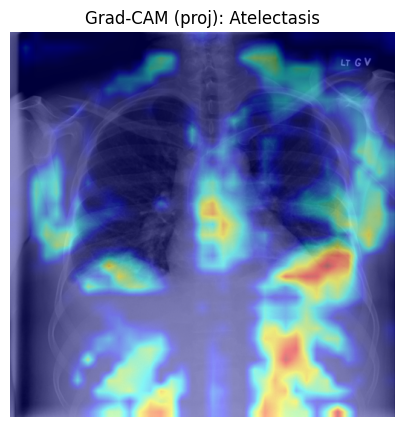

💾 Saved: gradcam_outputs/gradcam_Atelectasis.png


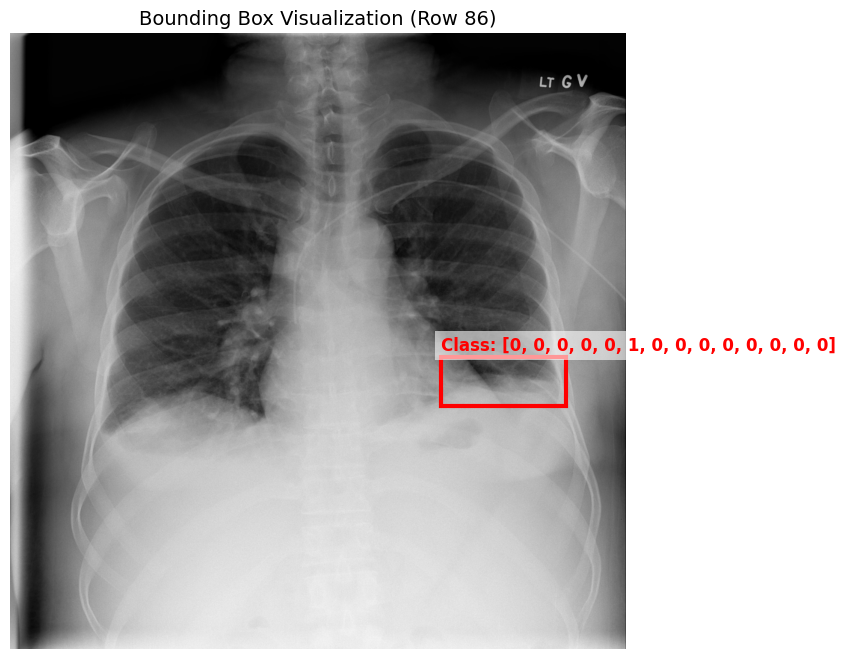

In [108]:
combined_visulizer(model, df_bbox, 86, thresholds, class_names)

Image: torch.Size([1, 3, 518, 518])
Age: torch.Size([1, 1])
Gender: torch.Size([1, 1])
Labels: torch.Size([1, 14])
Predictions: [[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1.]]


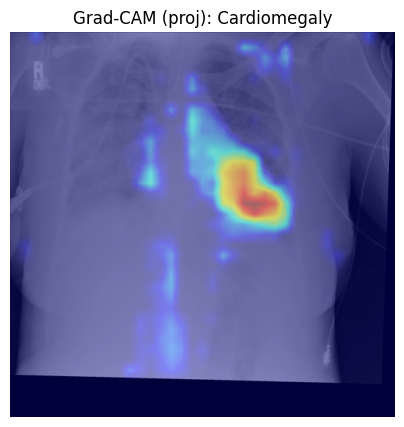

💾 Saved: gradcam_outputs/gradcam_Cardiomegaly.png


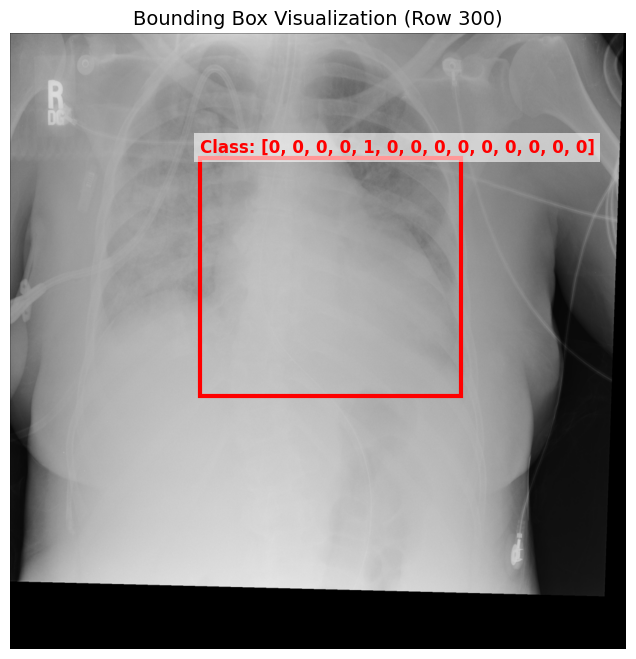

In [107]:
combined_visulizer(model, df_bbox, 300, thresholds, class_names)

Image: torch.Size([1, 3, 518, 518])
Age: torch.Size([1, 1])
Gender: torch.Size([1, 1])
Labels: torch.Size([1, 14])
Predictions: [[0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1.]]


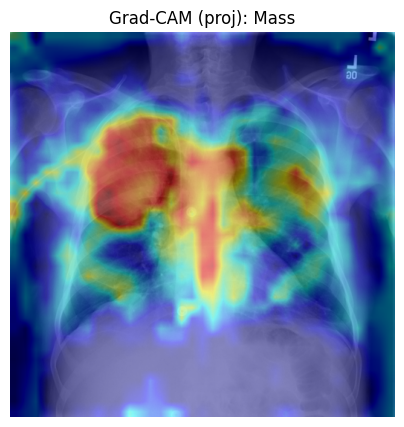

💾 Saved: gradcam_outputs/gradcam_Mass.png


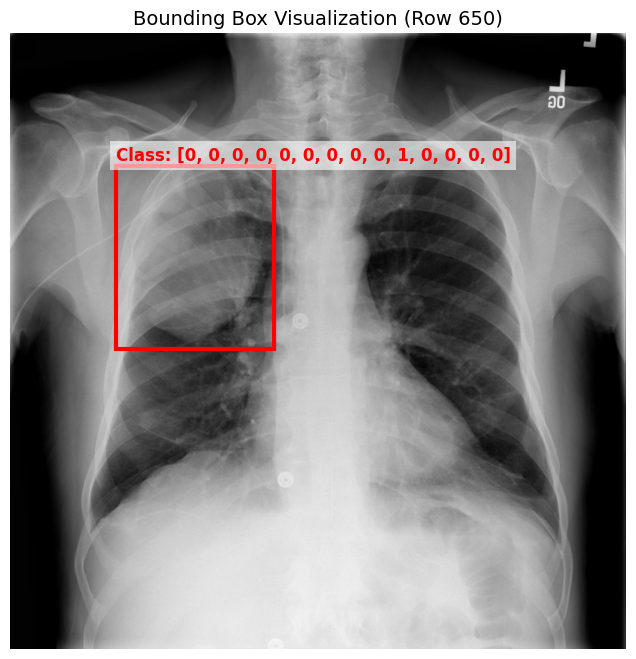

In [106]:
combined_visulizer(model, df_bbox, 650, thresholds, class_names)

Image: torch.Size([1, 3, 518, 518])
Age: torch.Size([1, 1])
Gender: torch.Size([1, 1])
Labels: torch.Size([1, 14])
Predictions: [[1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]]


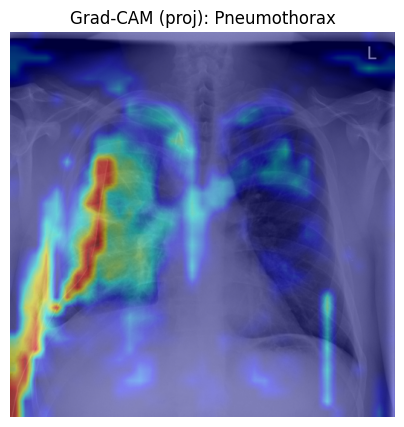

💾 Saved: gradcam_outputs/gradcam_Pneumothorax.png


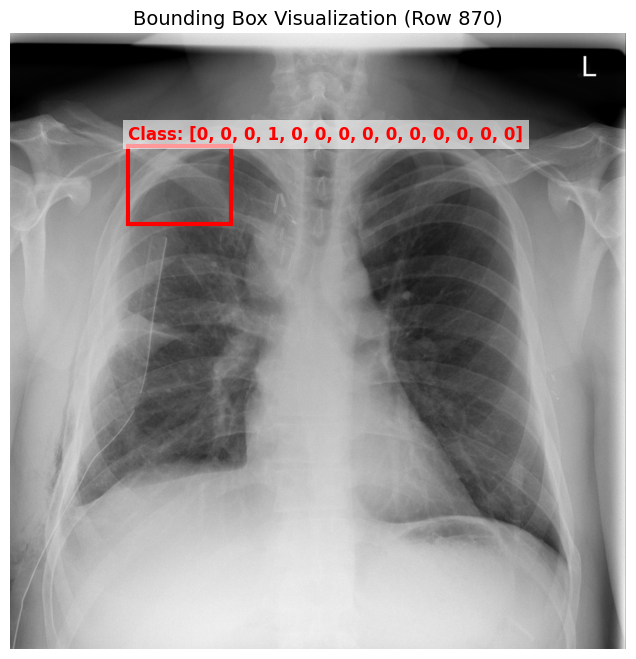

In [109]:
combined_visulizer(model, df_bbox, 870, thresholds, class_names)

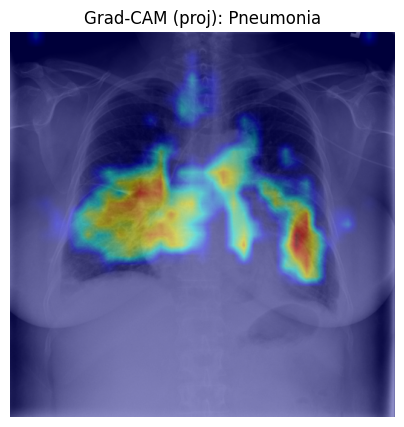

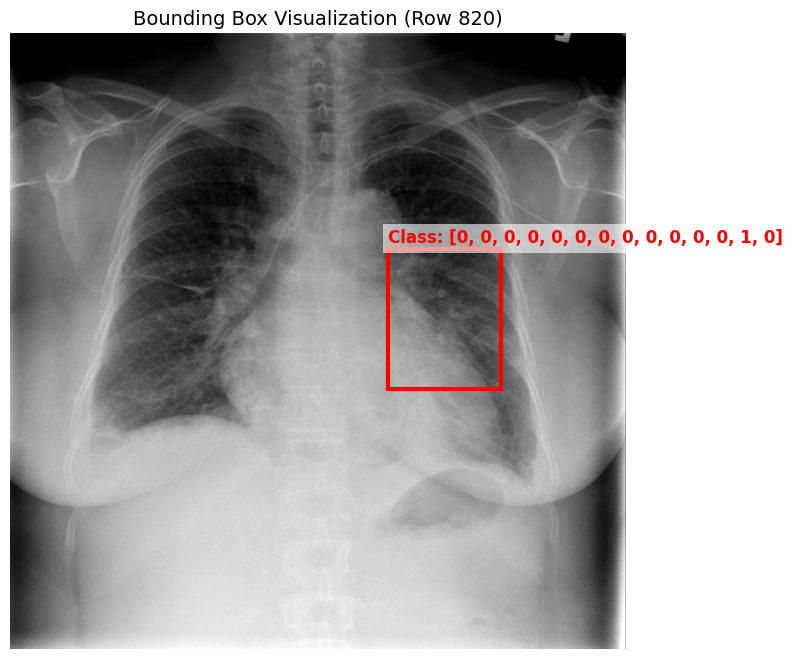

In [124]:
combined_visulizer(model, df_bbox, 820, thresholds, class_names)

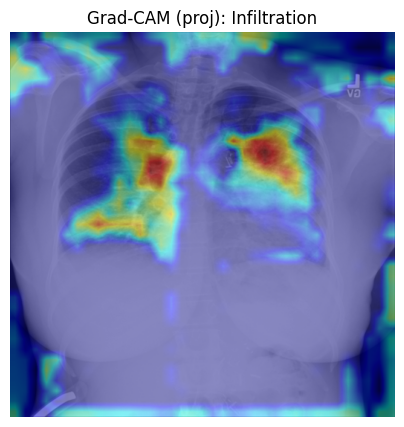

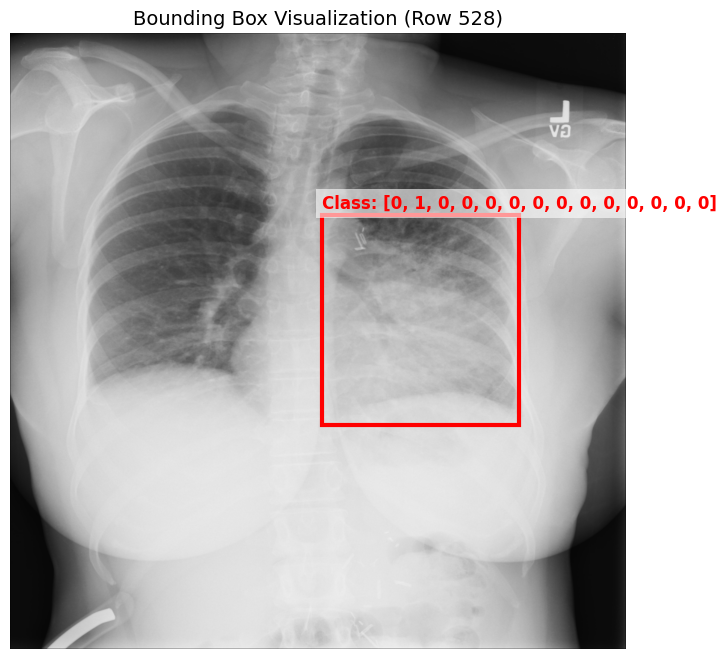

In [126]:
combined_visulizer(model, df_bbox, 528, thresholds, class_names)

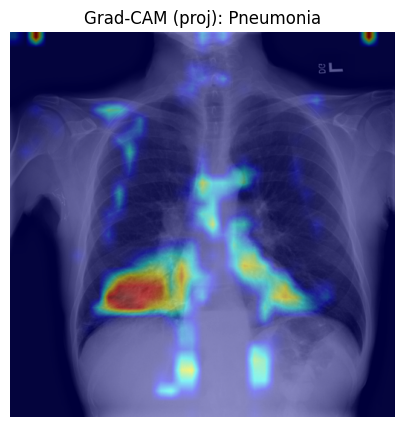

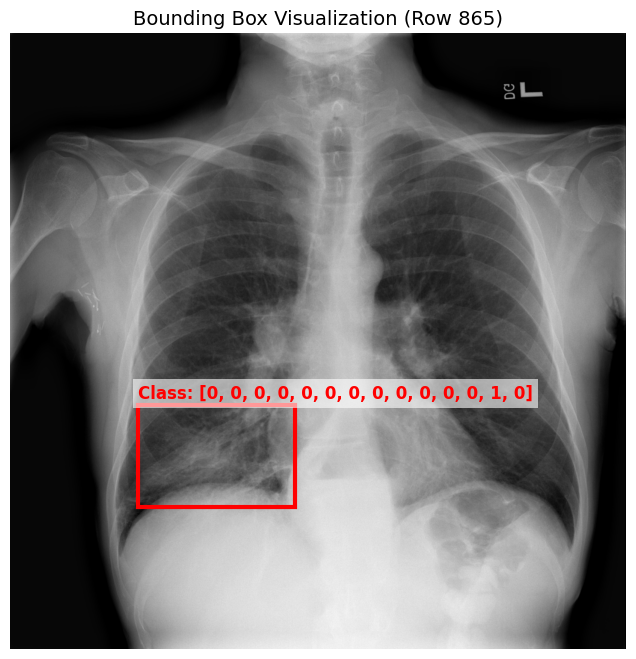

In [136]:
combined_visulizer(model, df_bbox, 865, thresholds, class_names)

In [116]:
import numpy as np
import matplotlib.pyplot as plt

def _capture_current_figure_rgb(fig):
    """Convert a matplotlib figure into an RGB numpy image."""
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(h, w, 3)
    return img

import cv2
import matplotlib.pyplot as plt
import numpy as np

def combined_visualizer_side_by_side(model, df, index, thresholds, class_names, device="cuda"):
    """
    Runs:
      1) generate_gradcam_explanations()  -> produces 1 or many CAM plots
      2) visualize_bbox()                -> produces bbox plot

    Captures the generated diagrams and displays them side-by-side.
    """

    # ----------------------------
    # 1) Capture bbox diagram
    # ----------------------------
    fig_bbox = plt.figure(figsize=(6, 6))
    visualize_bbox(df, index=index)
    bbox_img = _capture_current_figure_rgb(fig_bbox)
    plt.close(fig_bbox)

    # ----------------------------
    # 2) Capture gradcam diagrams
    # ----------------------------
    # Your gradcam prints multiple classes, each does plt.show().
    # We can't "capture" those directly unless we stop plt.show.
    # So we temporarily monkeypatch plt.show to capture figures.
    captured_gradcam_imgs = []

    original_show = plt.show

    def _patched_show(*args, **kwargs):
        fig = plt.gcf()
        img = _capture_current_figure_rgb(fig)
        captured_gradcam_imgs.append(img)
        plt.close(fig)  # close to avoid "below each other" plotting

    plt.show = _patched_show

    try:
        generate_gradcam_explanations(
            model=model,
            df=df,
            thresholds=thresholds,
            index=index,
            class_names=class_names,
            device=device,
            save_dir=None,
            alpha=0.45
        )
    finally:
        plt.show = original_show  # restore

    if len(captured_gradcam_imgs) == 0:
        print("⚠️ No GradCAM plots captured. Showing bbox only.")
        plt.figure(figsize=(6, 6))
        plt.imshow(bbox_img)
        plt.axis("off")
        plt.title("BBox")
        plt.show()
        return

    # ------------------------------------------------
    # 3) Resize and plot side-by-side
    # ------------------------------------------------
    for i, cam_img in enumerate(captured_gradcam_imgs):
        # Resize bbox to cam size (or vice versa)
        target_h, target_w = cam_img.shape[0], cam_img.shape[1]
        bbox_resized = cv2.resize(bbox_img, (target_w, target_h), interpolation=cv2.INTER_AREA)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(cam_img)
        axes[0].axis("off")
        axes[0].set_title(f"GradCAM Diagram #{i+1}")

        axes[1].imshow(bbox_resized)
        axes[1].axis("off")
        axes[1].set_title("BBox Diagram")

        plt.tight_layout()
        plt.show()


<Figure size 600x600 with 0 Axes>

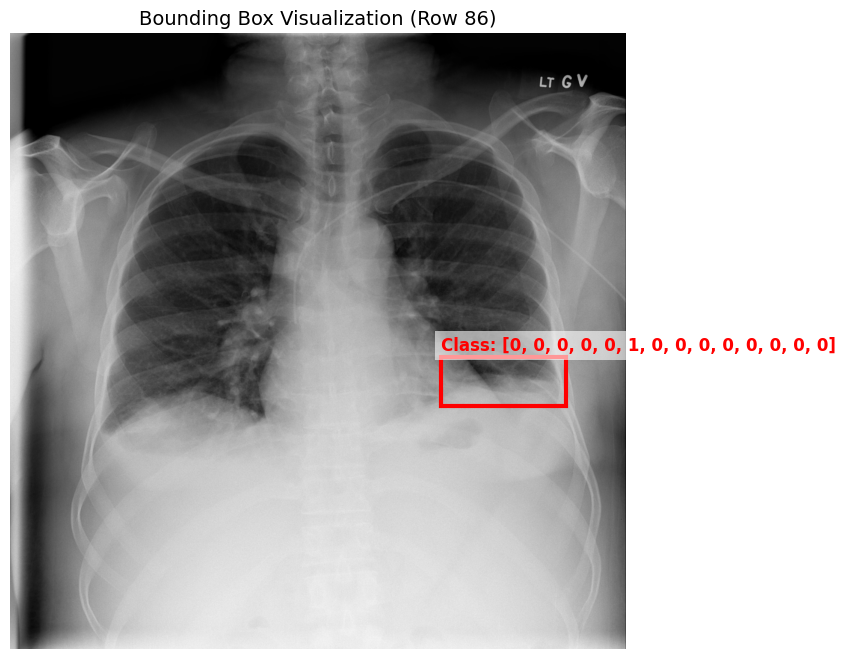

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239

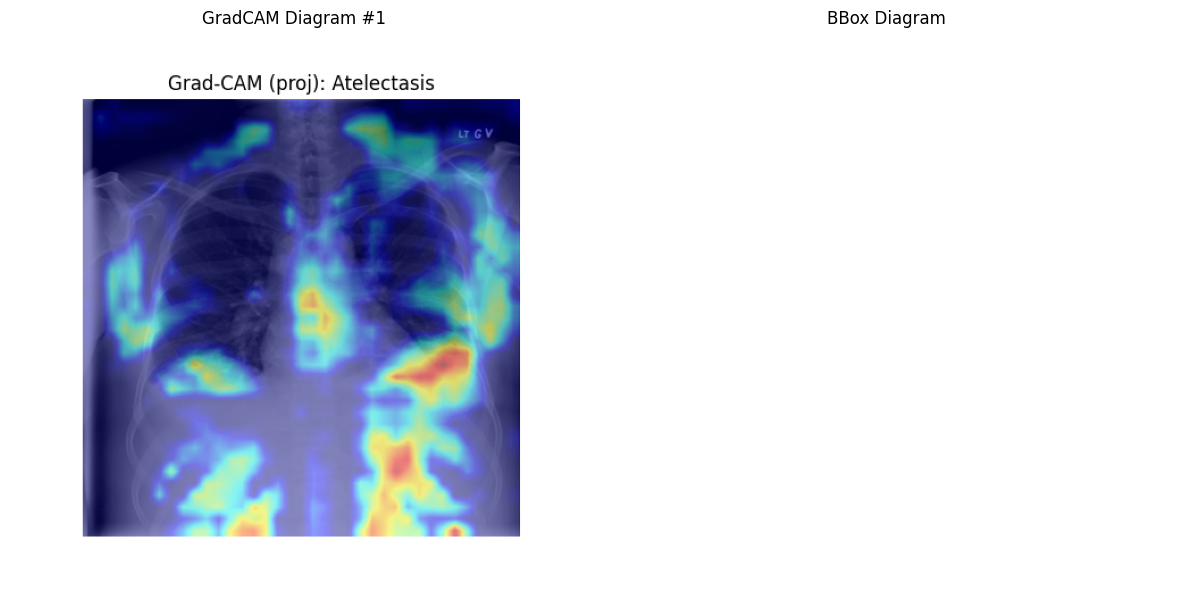

In [117]:
combined_visualizer_side_by_side(model, df_bbox, 86, thresholds, class_names)

In [ ]:
## DONE